In [62]:
import importlib
import src.utils.config_loader
importlib.reload(src.utils.config_loader)

from src.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
all_configs = config_loader.load_configs()
base_configs = config_loader.get_section(all_configs, "base")
graph_configs = config_loader.get_section(all_configs, "graph")
community_cfg = config_loader.get_section(all_configs, "community")

In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}") # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8


device(type='cuda')

In [3]:
# Preprocess data
import importlib
import src.modules.data_processor
importlib.reload(src.modules.data_processor)

from src.modules.data_processor import DataProcessor

print(base_configs)
data_processor = DataProcessor(base_configs=base_configs)
processed_data = data_processor.run(device=device, summarize=False)

{'paths': {'raw': 'data/raw/deb_label.csv', 'processed': 'data/processed'}, 'labels': {0: 'disagree', 1: 'neutral', 2: 'agree'}, 'subreddits': {'brexit': 0, 'blacklivesmatter': 1, 'climate': 2, 'democrats': 3, 'republican': 4}, 'required_columns': ['label', 'msg_id_parent', 'msg_id_child', 'submission_id', 'body_parent', 'body_child', 'submission_text', 'subreddit', 'author_parent', 'author_child', 'datetime', 'agreement_fraction', 'individual_kappa'], 'cleaning': {'normalize_subreddits': True, 'rename_columns': {'author_child': 'src_author', 'author_parent': 'dst_author', 'msg_id_child': 'src_comment_id', 'msg_id_parent': 'dst_comment_id', 'body_child': 'src_comment_text', 'body_parent': 'dst_comment_text', 'datetime': 'timestamp'}, 'timestamp_parsing': {'primary_format': '%d/%m/%Y %H:%M', 'dayfirst': True, 'error_handling': 'coerce', 'fallback_formats': ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M', '%Y-%m-%d']}, 'remove_self_replies': True}, 'temporal': {'infer_parent_comment_time': {'enab

In [4]:
# Build graphs
import importlib
import src.modules.graph_processor
importlib.reload(src.modules.graph_processor)

from src.modules.graph_processor import GraphProcessor

processed_path = base_configs.get('processed_path', 'data/processed')
pairs = processed_data.user_pairs
comments = processed_data.comments

graph_processor = GraphProcessor(graph_configs=graph_configs, processed_path=processed_path)
graph_data = graph_processor.run(pairs=pairs, embeddings_source=comments)

Building node features with pooling: mean
    + Total unique authors in pairs: 35257
    + Total pooled vectors: 35212
    + Pooled vector dimension: 384
Building graph snapshots: directed=True, wcc_mode=min_edges, edge_attrs=['mean_confidence', 'net_vector']
[Subreddit 0, T0] [WCC:min_edges] Nodes 32->29, Edges 86->84 (2.3% edges removed)
[Subreddit 0, T1] [WCC:min_edges] Nodes 30->30, Edges 79->79 (0.0% edges removed)
[Subreddit 0, T2] [WCC:min_edges] Nodes 31->31, Edges 59->59 (0.0% edges removed)
[Subreddit 0, T3] [WCC:min_edges] Nodes 43->43, Edges 107->107 (0.0% edges removed)
[Subreddit 0, T4] [WCC:min_edges] Nodes 53->53, Edges 134->134 (0.0% edges removed)
[Subreddit 0, T5] [WCC:min_edges] Nodes 71->71, Edges 266->266 (0.0% edges removed)
[Subreddit 0, T6] [WCC:min_edges] Nodes 79->79, Edges 187->187 (0.0% edges removed)
[Subreddit 0, T7] [WCC:min_edges] Nodes 96->94, Edges 177->176 (0.6% edges removed)
[Subreddit 0, T8] [WCC:min_edges] Nodes 187->187, Edges 611->611 (0.0% edg

c:\Users\vduch\OneDrive\ecs_msc_project\src\modules\graph_processor.py:177: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  x = torch.tensor(node_features, dtype=torch.float)


    + Created 77 PyG graphs
Saved PyG graphs to data/processed/pyg_graphs_384D.pt


In [5]:
# Load trained model and extract GNN node embeddings
import importlib
import src.utils.gnn_checkpointing
importlib.reload(src.utils.gnn_checkpointing)

from src.utils.gnn_checkpointing import load_model_checkpoint

ckpt_path = "checkpoints/best_model_2508152029.pth"
model_class_path = "src.models.multitask_debate_gnn.MultitaskDebateGNN"
gnn_model, gnn_ckpt = load_model_checkpoint(
    ckpt_path,
    device=device,
    model_class_path=model_class_path,
)

gnn_model.eval()
print(f"Loaded: {gnn_model.__class__.__name__}")
print(f"Checkpoint keys: {list(gnn_ckpt.keys())}")

Loading model checkpoint from checkpoints/best_model_2508152029.pth
Loaded: MultitaskDebateGNN
Checkpoint keys: ['state_dict', 'model_args', 'train_args']


In [ ]:
# Import the ECS processor
from src.modules.ecs_processor import ECSProcessor, create_ecs_processor

ecs_processor = create_ecs_processor(
    base_configs=base_configs,
    community_configs=community_cfg,
    gnn_model_path="checkpoints/best_model_2508152029.pth",
    gnn_model_class_path="src.models.multitask_debate_gnn.MultitaskDebateGNN",
    device=device   # type: ignore
)

# Process all graphs
pyg_graphs, graph_dict = graph_data.pyg_graphs, graph_data.graph_dict
processed_dict = ecs_processor.process_graphs(pyg_graphs, graph_dict)

# Get results DataFrame
ecs_df = ecs_processor.get_results_dataframe()
print(f"Processed {len(processed_dict)} subreddits")

# Save ecs dataframe
ecs_df.to_csv("results/ecs/all_ecs_data.csv", index=False)
print("Saved results/ecs/all_ecs_data.csv")

Loading model checkpoint from checkpoints/best_model_2508152029.pth
Loaded GNN model: MultitaskDebateGNN
Starting ECS processing for 77 graphs
Processing graph for subreddit: 0, timestep: 0
  Extracted node mapping: 29 nodes
  Graph stats: 29 nodes, 84 edges
Using device: cuda
  Communities found: 3
  Community sizes (min=6): [np.int64(13), np.int64(10), np.int64(6)]
  Modularity: 0.238
  EchoGAE ECI: 0.4924 | Community ECIs: ['0.3954', '0.6624', '0.4193']
  DebateGNN ECI: 0.5192 | Community ECIs: ['0.5976', '0.4440', '0.4745']
  **Embedding-Community Alignment Analysis**
    EchoGAE Embedding-Community Alignment:
    Silhouette Score: -0.0960 (higher = better separation)
    + Avg Intra-Community Distance: 0.6872
    + Avg Inter-Community Distance: 0.7225
    + Distance Ratio (Inter/Intra): 1.0515
    DebateGNN Embedding-Community Alignment:
    Silhouette Score: -0.0516 (higher = better separation)
    + Avg Intra-Community Distance: 0.4414
    + Avg Inter-Community Distance: 0.4673


Running complete ECS analysis with figure generation...
   + Color mode: lineage
Starting complete ECS analysis with pre-computed results...
Analyzing community evolution...
Computing evolution for brexit across 23 timesteps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

--- Timestep 0 -> 1 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.448
User Retention: 72.4%

--- Timestep 1 -> 2 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.400
User Retention: 70.0%

--- Timestep 2 -> 3 ---
Communities: 2 -> 4
Total Jaccard (Hungarian): 0.310
User Retention: 74.2%

--- Timestep 3 -> 4 ---
Communities: 4 -> 4
Total Jaccard (Hungarian): 0.669
User Retention: 79.1%

--- Timestep 4 -> 5 ---
Communities: 4 -> 3
Total Jaccard (Hungarian): 0.596
User Retention: 86.8%

--- Timestep 5 -> 6 ---
Communities: 3 -> 2
Total Jaccard (Hungarian): 0.462
User Retention: 78.9%

--- Timestep 6 -> 7 ---
Communities: 2 -> 2
Total Jaccard (Hungarian): 0.344
User Retentio

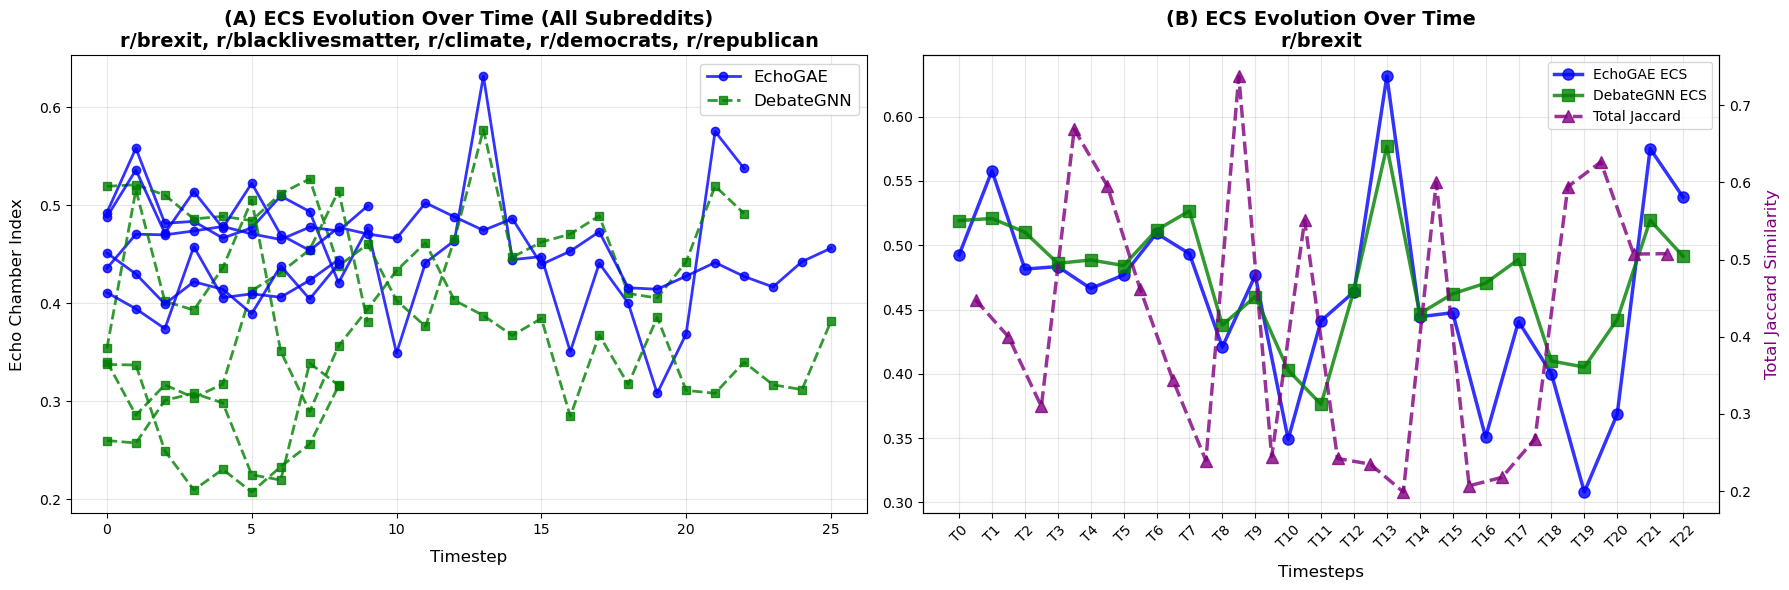

Debug - evolution_data type: <class 'dict'>
Debug - evolution_data keys: ['timesteps', 'ts_pairs', 'jaccard_matrices', 'hungarian_matches', 'total_jaccards', 'migration_stats', 'comm_ids_t1', 'comm_ids_t2']


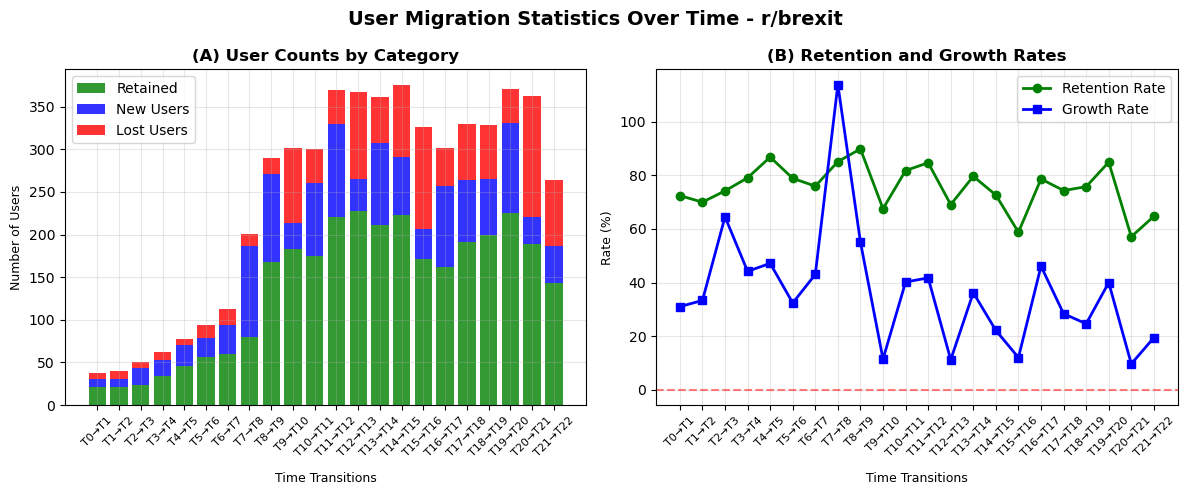

Plotting embedding comparison for timestep 12
  Overlap between nx_nodes and partition keys: 330/330
  Using lineage colors consistent with Sankey diagrams
Using 32 colors for lineage mode
Max communities per timestep: 7
  Community color map: {np.int64(0): '#808080', np.int64(1): '#800080', np.int64(2): '#FFFF00', np.int64(3): '#008080', np.int64(4): '#000000', np.int64(5): '#FFA500'}


  NetworkX coloring: 330 nodes with colors, 0 nodes without colors
  Community layout: 6 communities for positioning


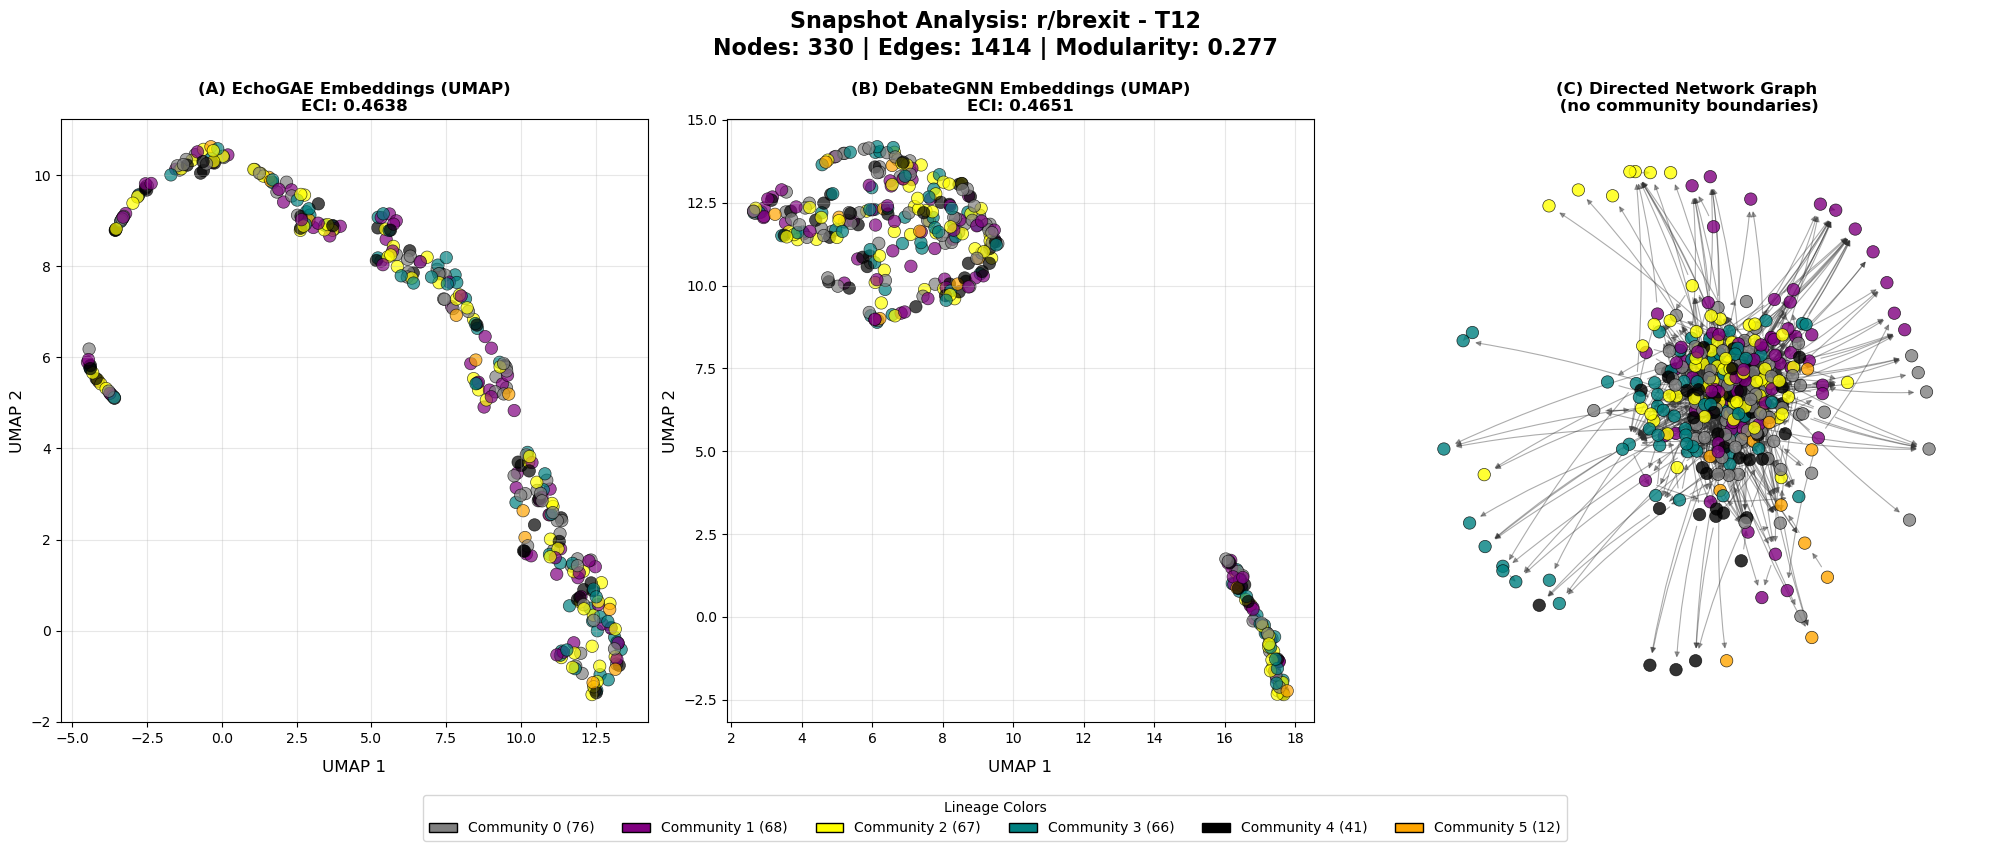


SNAPSHOT SUMMARY r/brexit - T12
Communities: 6
Nodes: 330
Edges: 1414
Modularity: 0.277
EchoGAE ECI: 0.4638
DebateGNN ECI: 0.4651
Color scheme: Lineage Colors
Boundaries drawn: False
  Community 0: 76 nodes, EchoGAE ECI: 0.4695, DebateGNN ECI: 0.4895
  Community 1: 68 nodes, EchoGAE ECI: 0.5244, DebateGNN ECI: 0.4437
  Community 2: 67 nodes, EchoGAE ECI: 0.4744, DebateGNN ECI: 0.4560
  Community 3: 66 nodes, EchoGAE ECI: 0.4110, DebateGNN ECI: 0.4449
  Community 4: 41 nodes, EchoGAE ECI: 0.4507, DebateGNN ECI: 0.4946
  Community 5: 12 nodes, EchoGAE ECI: 0.3599, DebateGNN ECI: 0.4937
Generating Figure 6: Network Evolution Grid...
  Using lineage colors for network evolution grid
Using 32 colors for lineage mode
Max communities per timestep: 7
Generating network evolution grid with 23 timesteps
Using color mode: lineage


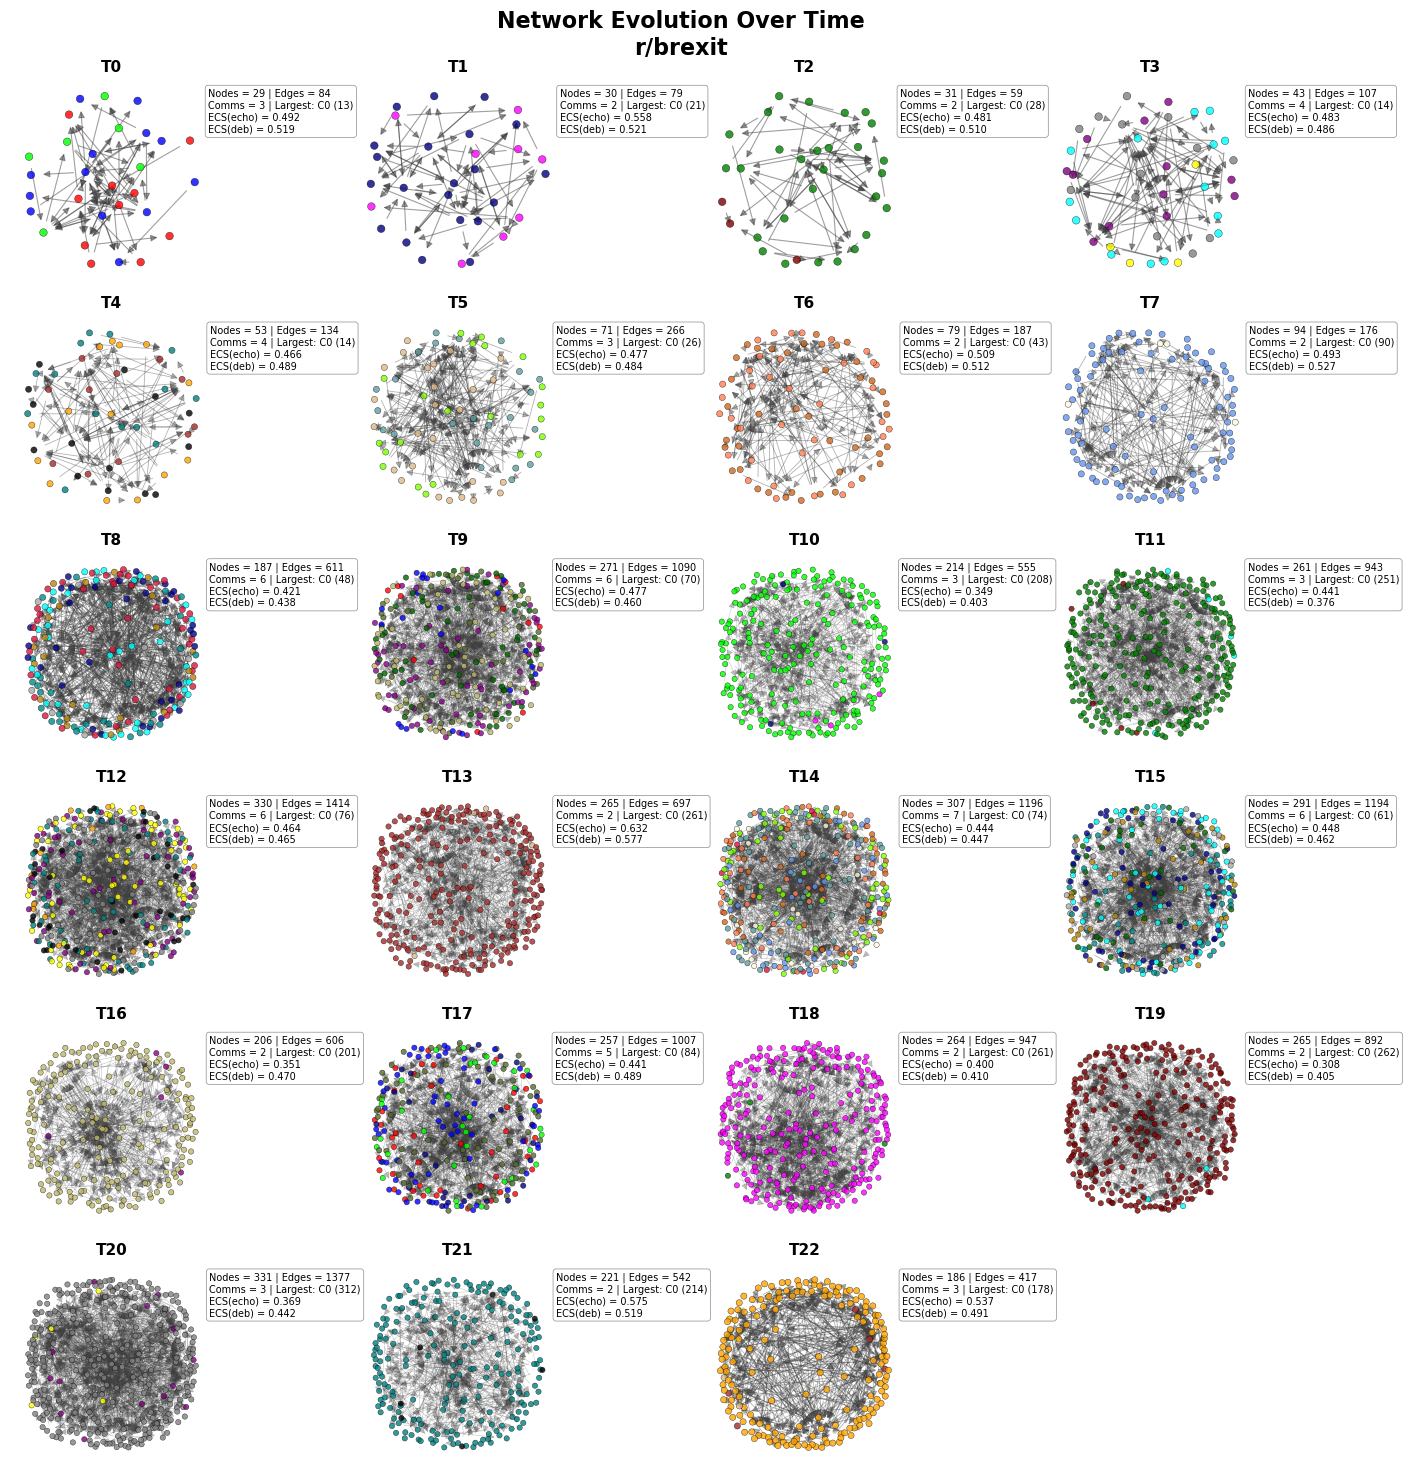


RESULTS SUMMARY
DATASET OVERVIEW:
   + Subreddits analyzed: 5
   + Total timesteps: 77
   + Total communities: 927

METHOD COMPARISON:
   + EchoGAE ECI: 0.454 ± 0.050
   + DebateGNN ECI: 0.381 ± 0.091
   + Paired t-test: t = 8.347, p = 0.000
   + Effect size (Cohen's d): 0.957 (large)
   + Significant difference: Yes

COMMUNITY EVOLUTION (r/brexit - ID 0):
   + Average Jaccard similarity: 0.418
   + Average retention rate: 75.5%
   + Average growth rate: 36.7%


,n_timesteps,modularity,echogae_eci,debgnn_eci,delta_echogae_eci,delta_debgnn_eci,echogae_silhouette,debgnn_silhouette
blacklivesmatter,10,0.852 ± 0.069,0.472 ± 0.015,0.376 ± 0.076,0.007 ± 0.014,0.005 ± 0.067,-0.211 ± 0.035,-0.362 ± 0.123
brexit,23,0.161 ± 0.14,0.462 ± 0.076,0.474 ± 0.048,0.002 ± 0.094,-0.001 ± 0.056,-0.103 ± 0.147,-0.08 ± 0.089
climate,26,0.431 ± 0.242,0.466 ± 0.032,0.375 ± 0.06,-0.001 ± 0.032,0.001 ± 0.071,-0.129 ± 0.068,-0.298 ± 0.12
democrats,9,0.18 ± 0.109,0.414 ± 0.025,0.28 ± 0.042,0.004 ± 0.04,0.007 ± 0.056,-0.197 ± 0.048,-0.456 ± 0.081
republican,9,0.342 ± 0.122,0.421 ± 0.021,0.264 ± 0.052,-0.001 ± 0.033,-0.003 ± 0.046,-0.198 ± 0.038,-0.497 ± 0.1
ALL,77,0.365 ± 0.279,0.454 ± 0.051,0.381 ± 0.092,0.001 ± 0.057,0.001 ± 0.061,-0.148 ± 0.101,-0.283 ± 0.181


In [127]:
import importlib
import src.visualization.ecs_plots
import src.visualization.snapshot_plots
import src.visualization.community_migration_plots
import src.visualization.community_sankey_plots
import src.utils.community_colors
importlib.reload(src.utils.community_colors)
importlib.reload(src.visualization.snapshot_plots)
importlib.reload(src.visualization.ecs_plots)
importlib.reload(src.visualization.community_migration_plots)
importlib.reload(src.visualization.community_sankey_plots)

import src.analysis.ecs_analyzer
importlib.reload(src.analysis.ecs_analyzer)

from src.analysis.ecs_analyzer import ECSAnalyzer

analyzer = ECSAnalyzer(output_dir='results')
results = analyzer.run_complete_analysis_with_figures(
    processed_dict=processed_dict,
    ecs_df=ecs_df,
    target_subreddit_id=0,
    embedding_timestep=12,
    # plot_all_embedding_timesteps=True,
    save_figures=False,
    color_mode="lineage"
)